In [27]:
import os, sys, re, shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [29]:
from pathlib import Path
def find_dataset_root(base="/content"):
    base = Path(base)
    candidates = []
    for entry in base.iterdir():
        if not entry.is_dir():
            continue
        if entry.name in ("drive", "sample_data"):
            continue
        subdirs = [p.name for p in entry.iterdir() if p.is_dir()]
        if '0' in subdirs and '1' in subdirs:
            return entry
        img_count = 0
        for ext in ("*.png","*.jpg","*.jpeg"):
            img_count += len(list(entry.rglob(ext)))
        if img_count >= 1000:
            candidates.append((entry, img_count))
    if candidates:
        candidates.sort(key=lambda x: -x[1])
        return candidates[0][0]
    if (Path("/content/archive")).exists():
        return Path("/content/archive")
    return None
RAW_DIR = find_dataset_root("/content")
if RAW_DIR is None:
    raise SystemExit("Couldn't auto-detect dataset folder.")
print("Detected dataset root at:", RAW_DIR)
print("Top-level entries of dataset root:")
!ls -la "{RAW_DIR}" | sed -n '1,200p'

Detected dataset root at: /content/data
Top-level entries of dataset root:
total 12
drwxr-xr-x 3 root root 4096 Sep 29 15:17 .
drwxr-xr-x 1 root root 4096 Sep 29 16:09 ..
drwxr-xr-x 4 root root 4096 Sep 29 15:17 processed


In [13]:
import shutil, os, re
from pathlib import Path
RAW_DIR = Path(RAW_DIR)
OUT_DIR = Path("/content/data/processed")
if OUT_DIR.exists():
    shutil.rmtree(OUT_DIR)
(OUT_DIR/'0').mkdir(parents=True, exist_ok=True)
(OUT_DIR/'1').mkdir(parents=True, exist_ok=True)
copied = 0
if (RAW_DIR/'0').exists() and (RAW_DIR/'1').exists():
    print("Dataset already has '0' and '1' folders; copying files into processed folder.")
    for label in ('0','1'):
        for p in (RAW_DIR/label).rglob('*'):
            if p.suffix.lower() in ('.png','.jpg','.jpeg'):
                dest = OUT_DIR/label/f"{copied}_{p.name}"
                shutil.copy(p, dest)
                copied += 1
else:
    print("Organizing images by inferring labels from folder names / filenames...")
    for root, dirs, files in os.walk(RAW_DIR):
        for fname in files:
            if not fname.lower().endswith(('.png','.jpg','.jpeg')):
                continue
            src = Path(root)/fname
            parent = src.parent.name
            label = None
            if parent in ('0','1'):
                label = parent
            else:
                m = re.search(r'[_\-\.\s](0|1)(?:\.[a-zA-Z]{3,4})?$', fname)
                if m:
                    label = m.group(1)
                else:
                    parts = [p for p in src.parts]
                    if '0' in parts:
                        label = '0'
                    elif '1' in parts:
                        label = '1'
            if label is None:
                continue
            dest = OUT_DIR/label/f"{copied}_{fname}"
            if not dest.exists():
                shutil.copy(src, dest)
                copied += 1
print(f"Copied {copied} images into {OUT_DIR}")
print("Counts -> 0:", len(list((OUT_DIR/'0').glob('*'))), "1:", len(list((OUT_DIR/'1').glob('*'))))
if copied == 0:
    raise SystemExit("No images were copied into processed folder. Inspect RAW_DIR and rerun the detection step.")

Organizing images by inferring labels from folder names / filenames...
Copied 555048 images into /content/data/processed
Counts -> 0: 397476 1: 157572


In [14]:
from sklearn.model_selection import train_test_split
import numpy as np
all_files = []
all_labels = []
for label in ('0','1'):
    for p in (OUT_DIR/label).glob('*'):
        all_files.append(str(p))
        all_labels.append(int(label))
print("Total images (processed):", len(all_files))
train_files, temp_files, train_labels, temp_labels = train_test_split(
    all_files, all_labels, test_size=0.2, stratify=all_labels, random_state=42)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)
print("Train:", len(train_files), "Val:", len(val_files), "Test:", len(test_files))

Total images (processed): 555048
Train: 444038 Val: 55505 Test: 55505


In [16]:
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (50,50)
BATCH_SIZE = 64
def preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, IMG_SIZE)
    return image, label
train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_ds = train_ds.shuffle(10000, seed=42).map(lambda x,y: preprocess(x,y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_files, val_labels)).map(lambda x,y: preprocess(x,y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels)).map(lambda x,y: preprocess(x,y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
print("Datasets ready. Example batch shapes:")
for xb, yb in train_ds.take(1):
    print(xb.shape, yb.shape)

Datasets ready. Example batch shapes:
(64, 50, 50, 3) (64,)


In [17]:
from sklearn.utils import class_weight
import numpy as np
class_weights_arr = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = {i: float(w) for i, w in enumerate(class_weights_arr)}
print("Class weights:", class_weights)

Class weights: {0: 0.6982146732037449, 1: 1.7612587956242018}


In [19]:
from tensorflow import keras
from tensorflow.keras import layers, models
def build_cancernet(input_shape=(50,50,3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    return model
model = build_cancernet()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')]
)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,649 (1.36 MB)

 Trainable params: 355,649 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
EPOCHS = 10
ckpt_path = "/content/CancerNet_best.h5"
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True)
]
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, class_weight=class_weights, callbacks=callbacks)
acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
for idx in (5,10):
    if len(acc) >= idx:
        print(f"Epoch {idx} - train_acc: {acc[idx-1]:.4f}, val_acc: {val_acc[idx-1]:.4f}")
    else:
        print(f"Only {len(acc)} epochs run; epoch {idx} not reached.")

Epoch 1/10
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7820 - loss: 0.4883 - precision: 0.5909 - recall: 0.7424

6939/6939 ━━━━━━━━━━━━━━━━━━━━ 423s 60ms/step - accuracy: 0.7820 - loss: 0.4883 - precision: 0.5909 - recall: 0.7424 - val_accuracy: 0.8149 - val_loss: 0.4242 - val_precision: 0.6308 - val_recall: 0.8393
Epoch 2/10
6936/6939 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8202 - loss: 0.4119 - precision: 0.6446 - recall: 0.8177

6939/6939 ━━━━━━━━━━━━━━━━━━━━ 191s 27ms/step - accuracy: 0.8202 - loss: 0.4119 - precision: 0.6446 - recall: 0.8177 - val_accuracy: 0.8420 - val_loss: 0.3695 - val_precision: 0.6805 - val_recall: 0.8360
Epoch 3/10
6936/6939 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8368 - loss: 0.3810 - precision: 0.6687 - recall: 0.8412

6939/6939 ━━━━━━━━━━━━━━━━━━━━ 170s 25ms/step - accuracy: 0.8368 - loss: 0.3810 - precision: 0.6687 - recall: 0.8412 - val_accuracy: 0.8581 - val_loss: 0.3317 - val_precision: 0.7246 - val_recall: 0.8067
Epoch 4/10
6938/6939 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8462 - loss: 0.3613 - precision: 0.6838 - recall: 0.8516

6939/6939 ━━━━━━━━━━━━━━━━━━━━ 127s 18ms/step - accuracy: 0.8462 - loss: 0.3613 - precision: 0.6838 - recall: 0.8516 - val_accuracy: 0.8650 - val_loss: 0.3210 - val_precision: 0.7379 - val_recall: 0.8134
Epoch 5/10
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 134s 19ms/step - accuracy: 0.8515 - loss: 0.3496 - precision: 0.6921 - recall: 0.8581 - val_accuracy: 0.8582 - val_loss: 0.3329 - val_precision: 0.7034 - val_recall: 0.8651
Epoch 6/10
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 126s 18ms/step - accuracy: 0.8560 - loss: 0.3384 - precision: 0.6992 - recall: 0.8637 - val_accuracy: 0.8544 - val_loss: 0.3367 - val_precision: 0.6916 - val_recall: 0.8794
Epoch 7/10
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 125s 18ms/step - accuracy: 0.8593 - loss: 0.3312 - precision: 0.7042 - recall: 0.8681 - val_accuracy: 0.8612 - val_loss: 0.3218 - val_precision: 0.7059 - val_recall: 0.8761
Epoch 8/10
6937/6939 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8627 - loss: 0.3236 - precision: 0.7098 - recall: 0.8722

6939/6939 ━━━━━━━━━━━━━━━━━━━━ 126s 18ms/step - accuracy: 0.8627 - loss: 0.3236 - precision: 0.7098 - recall: 0.8722 - val_accuracy: 0.8669 - val_loss: 0.3119 - val_precision: 0.7208 - val_recall: 0.8672
Epoch 9/10
6938/6939 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8654 - loss: 0.3162 - precision: 0.7139 - recall: 0.8761

6939/6939 ━━━━━━━━━━━━━━━━━━━━ 134s 19ms/step - accuracy: 0.8654 - loss: 0.3162 - precision: 0.7139 - recall: 0.8761 - val_accuracy: 0.8692 - val_loss: 0.3066 - val_precision: 0.7249 - val_recall: 0.8691
Epoch 10/10
6939/6939 ━━━━━━━━━━━━━━━━━━━━ 132s 19ms/step - accuracy: 0.8682 - loss: 0.3093 - precision: 0.7184 - recall: 0.8806 - val_accuracy: 0.8385 - val_loss: 0.3753 - val_precision: 0.6541 - val_recall: 0.9152
Epoch 5 - train_acc: 0.8526, val_acc: 0.8582
Epoch 10 - train_acc: 0.8685, val_acc: 0.8385


Evaluating on test set...
868/868 ━━━━━━━━━━━━━━━━━━━━ 32s 37ms/step - accuracy: 0.8657 - loss: 0.3170 - precision: 0.7153 - recall: 0.8671
Eval results (loss, accuracy, precision, recall): [0.3096964359283447, 0.8685703873634338, 0.7237676978111267, 0.8685029149055481]
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━

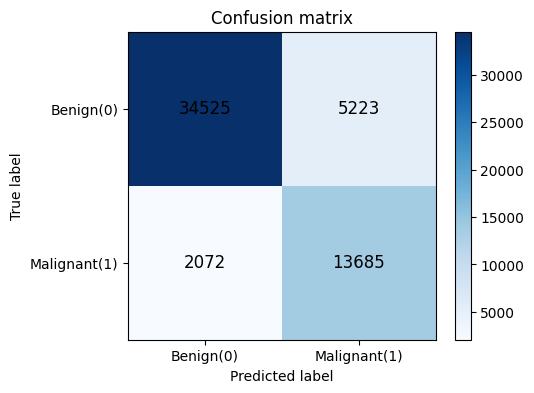

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
print("Evaluating on test set...")
eval_results = model.evaluate(test_ds)
print("Eval results (loss, accuracy, precision, recall):", eval_results)
y_true, y_pred = [], []
for xb, yb in test_ds:
    preds = model.predict(xb)
    y_true.extend(yb.numpy().astype(int).tolist())
    y_pred.extend((preds.flatten() > 0.5).astype(int).tolist())
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4))

import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion matrix')
plt.colorbar()
ticks = [0,1]
plt.xticks(ticks, ['Benign(0)','Malignant(1)'])
plt.yticks(ticks, ['Benign(0)','Malignant(1)'])
for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='black', fontsize=12)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


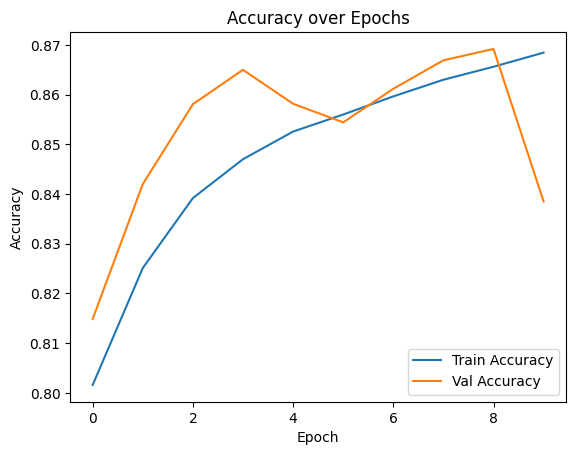

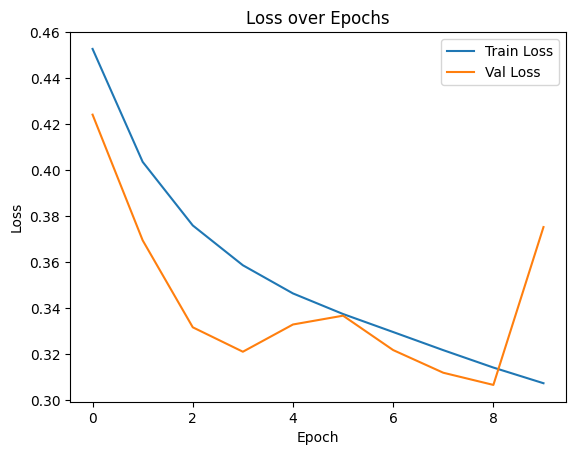

In [24]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.show()


In [28]:
model.save("CancerNet_model.keras")
print("Model saved as CancerNet_model.keras")


Model saved as CancerNet_model.keras


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


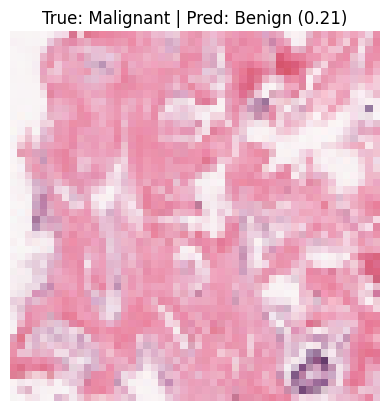

In [26]:
loaded_model = keras.models.load_model("CancerNet_model.keras")
sample_file = test_files[0]
sample_label = test_labels[0]
img = tf.io.read_file(sample_file)
img = tf.image.decode_png(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img, (50,50))
img_batch = tf.expand_dims(img, axis=0)
pred = loaded_model.predict(img_batch)[0][0]
plt.imshow(img)
plt.title(f"True: {'Malignant' if sample_label==1 else 'Benign'} | Pred: {'Malignant' if pred>0.5 else 'Benign'} ({pred:.2f})")
plt.axis("off")
plt.show()